<a href="https://colab.research.google.com/github/Noah-To/AML/blob/main/AML_assignment_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive and import libraries
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import os

# Mount Google Drive to access your files
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Load training and test image data
folder_path = "/content/drive/MyDrive/AMLfiles/faceAlignment"
train_data = np.load(f"{folder_path}/face_alignment_training_images.npz")
test_data = np.load(f"{folder_path}/face_alignment_test_images.npz")

# Extract images and facial landmark coordinates
train_images = train_data['images']  # shape: (N, H, W, 3)
train_points = train_data['points']  # shape: (N, P, 2)
test_images = test_data['images']    # shape: (T, H, W, 3)

# Show dataset dimensions
print("Training images:", train_images.shape)
print("Training points:", train_points.shape)
print("Test images:", test_images.shape)

Training images: (2811, 256, 256, 3)
Training points: (2811, 5, 2)
Test images: (554, 256, 256, 3)


In [3]:
# Convert images to grayscale and flatten
train_gray = train_images.mean(axis=-1)  # Convert RGB to grayscale
test_gray = test_images.mean(axis=-1)

# Flatten grayscale images for model input
N, H, W = train_gray.shape
T = test_gray.shape[0]
P = train_points.shape[1]  # number of landmark points

X_train = train_gray.reshape(N, H * W)
X_test = test_gray.reshape(T, H * W)
y_train = train_points.reshape(N, P * 2)  # Flatten landmark coordinates

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)


X_train: (2811, 65536)
y_train: (2811, 10)
X_test: (554, 65536)


In [4]:
# Create validation split for evaluation
X_train_split, X_value_split, y_train_split, y_value_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# Train Ridge Regression model
ridge_model = Ridge(alpha=1.0)
ridge_model = MultiOutputRegressor(ridge_model)
ridge_model.fit(X_train_split, y_train_split)

ridge_value_predict = ridge_model.predict(X_value_split)
ridge_value_error = np.linalg.norm(ridge_value_predict - y_value_split, axis=1)


In [7]:
# Train Linear Regression model for comparison
lin_model = LinearRegression()
lin_model = MultiOutputRegressor(lin_model)
lin_model.fit(X_train_split, y_train_split)

lin_value_predict = lin_model.predict(X_value_split)
lin_value_error = np.linalg.norm(lin_value_predict - y_value_split, axis=1)


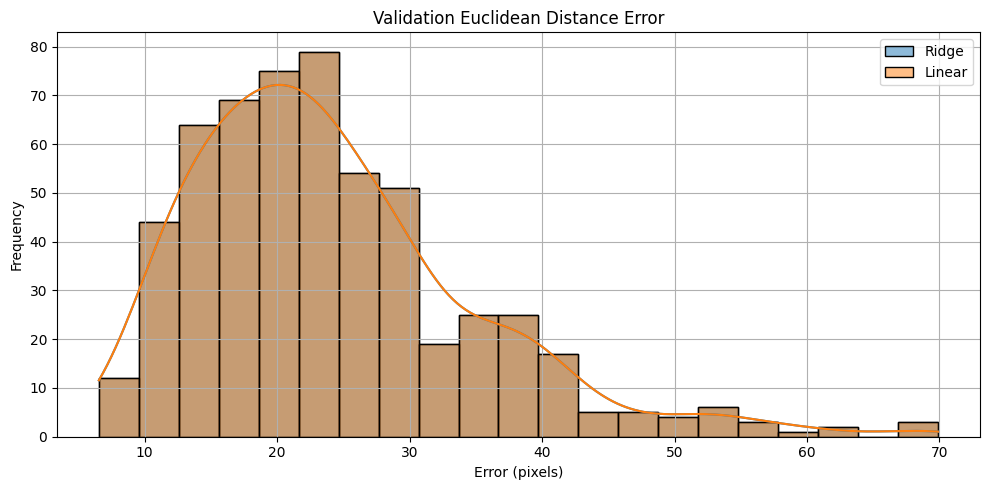

In [8]:
# Plot error distribution for both models
plt.figure(figsize=(10, 5))
sns.histplot(ridge_value_error, label='Ridge', kde=True)
sns.histplot(lin_value_error, label='Linear', kde=True)
plt.title("Validation Euclidean Distance Error")
plt.xlabel("Error (pixels)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# Print mean and standard deviation for both models
print("Ridge Regression - Mean ± Std:", np.mean(ridge_value_error), "+/-", np.std(ridge_value_error))
print("Linear Regression - Mean ± Std:", np.mean(lin_value_error), "+/-", np.std(lin_value_error))#

Ridge Regression - Mean ± Std: 24.084558877709092 +/- 10.635435754295136
Linear Regression - Mean ± Std: 24.084560543377332 +/- 10.63543624397905


In [10]:
# Predict on test data and save as CSV
ridge_test_predict = ridge_model.predict(X_test).reshape(T, P, 2)
lin_test_predict = lin_model.predict(X_test).reshape(T, P, 2)

# Flatten for saving (each row = x1, y1, x2, y2, ..., xP, yP)
ridge_csv = ridge_test_predict.reshape(T, -1)
lin_csv = lin_test_predict.reshape(T, -1)

np.savetxt(f"{folder_path}/ridge_test_predict.csv", ridge_csv, delimiter=',')
np.savetxt(f"{folder_path}/linear_test_predict.csv", lin_csv, delimiter=',')

print("Saved predictions to CSV:")
print("- ridge_test_predict.csv")
print("- linear_test_predict.csv")


Saved predictions to CSV:
- ridge_test_predict.csv
- linear_test_predict.csv
